In [1]:
# import json
# with open('prompt1.json', 'r') as file:
#     openai_resp = json.load(file)

In [1]:
import pandas as pd
# df_resul
# openai_resp=pd.DataFrame(openai_resp)

In [2]:
# openai_resp

In [3]:
#remove other and complicated labels 
# df_results0 = openai_resp[~openai_resp['label'].isin(['complicated/hard to categorise', 'other'])]
df_results0 = pd.read_csv('../data/naacl-woah-results/sample-500-run_gpt-4-0125-preview_naacl.csv')

In [5]:
# df_results0 = openai_resp.reset_index()
df_results0.head()

,original_id,original_input,label,openai_resp,language,task
0,2619,"რაც ""ნაციონალურმა მოძრაობამ"" 8 წელიწადში აჭარა...",true,50,ka,gpt-4-0125-zero-shot-100-threshold
1,456,Przez ostatni rok bezrobocie osiągnęło w Niemc...,true,50,pl,gpt-4-0125-zero-shot-100-threshold
2,102,Os estados onde você teve a maior piora no nív...,false,50,pt,gpt-4-0125-zero-shot-100-threshold
3,3037,Foto Unjuk Rasa Driver Go-Jek Hasil Suntingan,partly true/misleading,50,id,gpt-4-0125-zero-shot-100-threshold
4,1126,Orientações de prevenção ao corona vírus (sic)...,false,0,pt,gpt-4-0125-zero-shot-100-threshold


In [6]:
from sklearn.metrics import classification_report

In [7]:
import numpy as np
def gpt_tv(row):
    resp = row['openai_resp']
    try:
        resp = float(resp)
    except ValueError:
        return "unknown"
    
    if resp > 50: #TODO: tune this value?
        return 1
    
    else:
        return 0

def conservative_true_row(row):
    if row['label'] in ['false', 'mostly false', 'partly true/misleading']: #TODO: tune these
        return 0
    else:
        return 1

df_results0['openai_simple'] = df_results0.apply(gpt_tv, axis=1)
df_results0['simple_truth'] = df_results0.apply(conservative_true_row, axis=1)

# print(df_results0.shape)
df_processed = df_results0.copy().drop(df_results0[(df_results0.openai_simple != 0) & (df_results0.openai_simple != 1)].index)
df_processed = df_processed.drop(df_processed[df_processed.label.isin(['complicated/hard to categorise', 'other', np.nan])].index)
df_processed = df_processed.reset_index()

In [8]:
print(classification_report(df_processed['simple_truth'].values.tolist(), df_processed['openai_simple'].values.tolist()))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80       306
           1       0.66      0.18      0.28       162

    accuracy                           0.68       468
   macro avg       0.67      0.56      0.54       468
weighted avg       0.68      0.68      0.62       468



In [9]:
def euro_or_not(lang):
    if lang in ["de", "es", "fr", "it", "no", "nl", "pl", "pt", "ro", "ru", "sr", "sq"]: #german, spanish, french, italian, norwegian, dutch, polish
        return True
    else: #ar - arabic; az - azerbaijani; bn - bengali; fa - farsi; gu - gujarati; hi - hindi; id - indonesian
        #ka - georgian; mr - marathi; pa - punjabi; si - sinhala; ta - tamil; tr - turkish
        return False

In [10]:
def conservative_true(label):
    if label in ['false', 'mostly false', 'partly true/misleading']: #TODO: tune these
        return 0
    else:
        return 1

In [14]:
euro_y_true = []
euro_y_pred = []
non_euro_y_true = []
non_euro_y_pred = []
for i in range(df_processed.shape[0]):
    if euro_or_not(df_processed['language'][i]):
        euro_y_true.append(conservative_true(df_processed['label'][i]))
        euro_y_pred.append(df_processed['openai_simple'][i])
    else:
        non_euro_y_true.append(conservative_true(df_processed['label'][i]))
        non_euro_y_pred.append(df_processed['openai_simple'][i])

In [15]:
print(classification_report(euro_y_true, euro_y_pred))

              precision    recall  f1-score   support

           0       0.61      0.94      0.74       145
           1       0.73      0.22      0.34       110

    accuracy                           0.63       255
   macro avg       0.67      0.58      0.54       255
weighted avg       0.66      0.63      0.57       255



In [16]:
print(classification_report(non_euro_y_true, non_euro_y_pred))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       161
           1       0.45      0.10      0.16        52

    accuracy                           0.75       213
   macro avg       0.61      0.53      0.51       213
weighted avg       0.69      0.75      0.68       213



In [17]:
def western(lang):
    if lang in ["de", "es", "fr", "it", "nl", "no", "pt"]:
        return True
    else:
        return False

In [19]:
western_y_true = []
western_y_pred = []
non_western_y_true = []
non_western_y_pred = []
for i in range(df_processed.shape[0]):
    if western(df_processed['language'][i]):
        western_y_true.append(conservative_true(df_processed['label'][i]))
        western_y_pred.append(df_processed['openai_simple'][i])
    else:
        non_western_y_true.append(conservative_true(df_processed['label'][i]))
        non_western_y_pred.append(df_processed['openai_simple'][i])

In [20]:
print(classification_report(western_y_true, western_y_pred))

              precision    recall  f1-score   support

           0       0.62      0.94      0.75       108
           1       0.68      0.17      0.27        76

    accuracy                           0.62       184
   macro avg       0.65      0.56      0.51       184
weighted avg       0.65      0.62      0.55       184



In [21]:
print(classification_report(non_western_y_true, non_western_y_pred))

              precision    recall  f1-score   support

           0       0.73      0.95      0.83       198
           1       0.64      0.19      0.29        86

    accuracy                           0.72       284
   macro avg       0.68      0.57      0.56       284
weighted avg       0.70      0.72      0.66       284



In [22]:
def small(lang):
    if lang in ["no", "nl", "pl", "ro", "sr", "sq", "az", "ka", "si"]:
        return True
    else: return False

In [23]:
small_y_true = []
small_y_pred = []
large_y_true = []
large_y_pred = []
for i in range(df_processed.shape[0]):
    if small(df_processed['language'][i]):
        small_y_true.append(conservative_true(df_processed['label'][i]))
        small_y_pred.append(df_processed['openai_simple'][i])
    else:
        large_y_true.append(conservative_true(df_processed['label'][i]))
        large_y_pred.append(df_processed['openai_simple'][i])

In [24]:
print(classification_report(small_y_true, small_y_pred))

              precision    recall  f1-score   support

           0       0.55      0.95      0.70        59
           1       0.81      0.22      0.35        58

    accuracy                           0.59       117
   macro avg       0.68      0.59      0.53       117
weighted avg       0.68      0.59      0.53       117



In [25]:
print(classification_report(large_y_true, large_y_pred))

              precision    recall  f1-score   support

           0       0.73      0.95      0.82       247
           1       0.57      0.15      0.24       104

    accuracy                           0.72       351
   macro avg       0.65      0.55      0.53       351
weighted avg       0.68      0.72      0.65       351



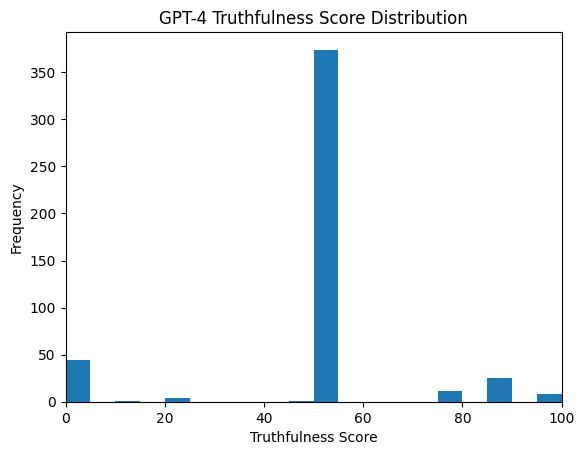

In [31]:
import matplotlib.pyplot as plt
plt.hist(df_processed['openai_resp'].map(float).values,bins=20)
plt.title("GPT-4 Truthfulness Score Distribution")
plt.xlim(0,100)
plt.ylabel("Frequency")
# plt.yscale('log')
plt.xlabel("Truthfulness Score")
plt.show()